
<font size="12">**Spike cross-correlation demo**</font>

The Spike cross-correlation script has been developed during my research work. If you use it in your work, please cite the following works.

References: 

    1. Garofalo, M., Nieus, T., Massobrio, P., and Martinoia, S. (2009). Evaluation of the Performance of Information Theory-Based Methods and Cross-Correlation to Estimate the Functional Connectivity in Cortical Networks. PLoS ONE 4, e6482. doi: 10.1371/journal.pone.0006482.
    
    2. Nieus, T., D’Andrea, V., Amin, H., Di Marco, S., Safaai, H., Maccione, A., et al. (2018). State-dependent representation of stimulus-evoked activity in high-density recordings of neural cultures. Sci Rep 8, 5578. doi: 10.1038/s41598-018-23853-x.

In [1]:
import numpy as np
import pylab as plt

In [2]:
import spike_cross_corr as scc

# Load data and perform some preliminary analysis

In [3]:
# get the data from the web ... 
import os
if not(os.path.isdir('data')):
    print("Folder <<data>> created!")
    os.makedirs('data')
if not(os.path.isfile('data/data.npy')):
    print("Transfer data.npy!")
    str_get = "https://unimi2013-my.sharepoint.com/:u:/g/personal/thierry_nieus_unimi_it/EYxkNBwY_LNNvaYMNoYQMOMBm0EBC-hHMdMMs23KfSVTLg?e=NHjjXA&download=1"
    os.system("wget --no-check-certificate \"%s\" -q -O data/data.npy" % str_get)
fn = 'data/data.npy'

In [4]:
spk_trains_tmp, id_ch_tmp, tmax = scc.load_data(fn)
tmax /= 1000 # tmax in seconds
print('%d spike trains loaded ' % len(spk_trains_tmp))
print('max time of recording (s) %g ' %tmax)

793 spike trains loaded 
max time of recording (s) 565.398 


## Filter data.

In [5]:
mfr_min = 0.1 # Hz
spk_trains, id_ch = [], []
mfr_lst = []
for st, ic in zip(spk_trains_tmp, id_ch_tmp):
    mfr = len(st) / tmax  # Hz    
    if mfr > mfr_min:
        # spike train has enough spikes
        spk_trains.append(st)
        id_ch.append(ic)
        mfr_lst.append(mfr)
print('%d spike trains retained ' % len(spk_trains))        

793 spike trains retained 


## Report distribution of mean firing rates.

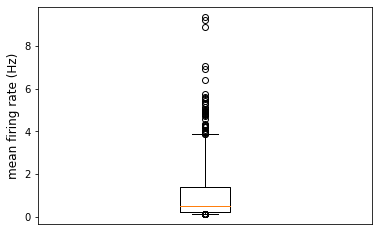

In [6]:
plt.boxplot(mfr_lst, whis=[5, 95])
plt.xticks([])
plt.ylabel('mean firing rate (Hz)', fontsize=12);

# Compute spike cross-correlation

In [7]:
# Format data to run cross-correlation procedure.
idx_spk_tr, len_spk_tr = scc.format_spike_train(spk_trains)

In [8]:
n_jobs = 4
cc_lst, idx_sd, tcc = scc.run_cross_par(idx_spk_tr, len_spk_tr, n_jobs=n_jobs)

cross-corr computed in 162.278 seconds


## Analyze the correlations

In [9]:
# Define some useful functions
def get_row_col(id_ch):
    """Return row and column of channel id_ch."""
    row = id_ch // 64
    col = id_ch % 64    
    return row, col

def chan_dist(rc_src, rc_dst):
    """Compute distance between two channels/electrodes."""
    pitch = 80 # um
    d2 = (rc_src[0] - rc_dst[0])**2 + (rc_src[1] - rc_dst[1])**2
    d = np.sqrt(d2) * pitch
    return d

In [10]:
dout = {}
keys = ['cc-peak', 'cc-peak-time-lag (ms)', 'distance (um)', 'velocity (mm/s)']
for key in keys:
    dout[key] = []

for k, cc in enumerate(cc_lst):
    # cc-max
    cc_max = np.max(cc)
    idx_max = np.argmax(cc)
    t_peak = tcc[idx_max]
    # distance
    idx_src, idx_dst = idx_sd[k]
    rc_src = get_row_col(id_ch[idx_src])
    rc_dst = get_row_col(id_ch[idx_dst])
    dist = chan_dist(rc_src, rc_dst)
    # velocity
    if t_peak:
        vel = dist / t_peak  # um / ms = mm/s
    else:
        vel = 1e10
    # store results
    dout['cc-peak'].append(cc_max)
    dout['cc-peak-time-lag (ms)'].append(t_peak)
    dout['distance (um)'].append(dist)
    dout['velocity (mm/s)'].append(abs(vel))

In [11]:
# define data frame and rank it based on the spike cross-correlation values (from highest to lowest)
import pandas as pd
df = pd.DataFrame(dout)
df.sort_values('cc-peak', ascending=False, inplace=True)
df.head(n=20)

,cc-peak,cc-peak-time-lag (ms),distance (um),velocity (mm/s)
83193,0.393688,0.0,80.000000,1.000000e+10
303443,0.393072,0.5,80.000000,1.600000e+02
130770,0.233971,1.5,252.982213,1.686548e+02
139738,0.232833,-0.5,288.444102,5.768882e+02
202417,0.134928,0.0,80.000000,1.000000e+10
44307,0.133242,0.5,288.444102,5.768882e+02
84551,0.132200,-2.5,4882.622246,1.953049e+03
202889,0.126762,0.0,80.000000,1.000000e+10
233440,0.124308,0.0,80.000000,1.000000e+10
151876,0.123967,0.0,80.000000,1.000000e+10


In [12]:
ccmat = scc.calc_cc_sp(idx_spk_tr, len_spk_tr, scc.params)

/home/tnieus/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cross-corr computed in 4.73 seconds 



In [13]:
idx_to_sel = np.triu_indices(len(len_spk_tr), k = 1)

ccpeaks = ccmat.max(axis=0)[idx_to_sel]
ccpeaks_sort = np.sort(ccpeaks)[::-1]
print('Max absolute difference between the two algorithms = %g ' % np.max(np.abs(df['cc-peak'].to_numpy()-ccpeaks_sort)))

Max absolute difference between the two algorithms = 0.000146434 
